In [1]:
from pathlib import Path

In [2]:
import matplotlib.pyplot as plt
import xarray as xr
import numpy as np
import rasterio
import openeo

### Purpose

This notebook documents an issue observed with the `apply_neighborhood` process in OpenEO. After application of the processes, the area appears shifted and pixels resampled. If no overlap is specfied, the issue does not appear.

### Input data

In [3]:
connection = openeo.connect(
    "https://openeo.dataspace.copernicus.eu"
).authenticate_oidc()

Authenticated using refresh token.


In [4]:
# spatial_extent_entire_granule = {
#    "west": -15.936301,
#    "south": 15.288158,
#    "east": -14.909093,
#    "north": 16.278762,
# }
spatial_extent_smaller = {
    "west": -15.224,
    "south": 15.283,
    "east": -14.91,
    "north": 15.55,
}

spatial_extent = spatial_extent_smaller
temporal_extent = ["2023-09-11", "2023-09-12"]

In [5]:
UDF_NOOP_CODE = """
from scipy.ndimage import distance_transform_edt
import numpy as np
import xarray as xr
from openeo.udf import XarrayDataCube

def apply_datacube(cube: XarrayDataCube, context: dict) -> XarrayDataCube:
    return cube
"""

In [6]:
run_openeo = True

noop_udf = openeo.UDF(UDF_NOOP_CODE)
patch_length_x = 120
patch_length_y = 120
overlap_length = 20

In [7]:
openeo_results_base_path = Path("test_data")
openeo_results_base_path.mkdir(exist_ok=True)
s2_cloud_mask_coarse_path = openeo_results_base_path / "s2_cloud_mask_coarse.nc"
udf_overlap_path = openeo_results_base_path / "udf_overlap.nc"
udf_no_overlap_path = openeo_results_base_path / "udf_no_overlap.nc"

In [8]:
scl = connection.load_collection(
    "SENTINEL2_L2A",
    spatial_extent=spatial_extent,
    temporal_extent=temporal_extent,
    bands=["SCL"],
).band("SCL")
cloud_mask = (scl == 0) | (scl == 3) | (scl > 7)
cloud_mask_mean = (cloud_mask * 1.0).resample_spatial(resolution=300, method="average")
cloud_mask_coarse = cloud_mask_mean >= 0.05

udf_overlap = cloud_mask_coarse.apply_neighborhood(
    noop_udf,
    size=[
        {"dimension": "t", "value": "P1D"},
        {"dimension": "x", "value": patch_length_x, "unit": "px"},
        {"dimension": "y", "value": patch_length_y, "unit": "px"},
    ],
    overlap=[
        {"dimension": "x", "value": overlap_length, "unit": "px"},
        {"dimension": "y", "value": overlap_length, "unit": "px"},
    ],
)
udf_no_overlap = cloud_mask_coarse.apply_neighborhood(
    noop_udf,
    size=[
        {"dimension": "t", "value": "P1D"},
        {"dimension": "x", "value": patch_length_x, "unit": "px"},
        {"dimension": "y", "value": patch_length_y, "unit": "px"},
    ],
    overlap=None,
)

In [9]:
if run_openeo:
    cloud_mask_coarse.download(s2_cloud_mask_coarse_path)
    udf_overlap.download(udf_overlap_path)
    udf_no_overlap.download(udf_no_overlap_path)

### Visualization

In [10]:
da_cloud_mask_coarse = xr.open_dataset(s2_cloud_mask_coarse_path)["var"]
da_udf_overlap = xr.open_dataset(udf_overlap_path)["var"]
da_udf_no_overlap = xr.open_dataset(udf_no_overlap_path)["var"]

/home/hannes/micromamba/envs/testing/lib/python3.11/site-packages/xarray/backends/plugins.py:110: RuntimeWarning: Engine 'olciefrsafeengine' loading failed:
libxml2.so.2: cannot open shared object file: No such file or directory
  external_backend_entrypoints = backends_dict_from_pkg(entrypoints_unique)


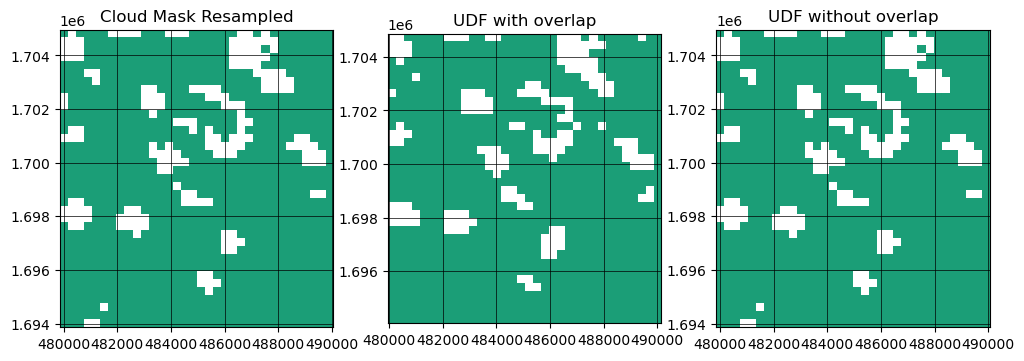

In [12]:
fig, axs = plt.subplots(1, 3, figsize=(12, 5))

cloud_mask_coarse_ax, udf_overlap_ax, udf_no_overlap_ax = axs

selection = dict(
    x=slice(480000, 490000),
    y=slice(1.705 * 1e6, 1.694 * 1e6),
    t="2023-09-11",
)

cloud_mask_coarse_subset = da_cloud_mask_coarse.sel(selection)
udf_overlap_subset = da_udf_overlap.sel(selection)
udf_no_overlap_subset = da_udf_no_overlap.sel(selection)

imshow_args = {
    "cmap": "Dark2",
    "vmin": 0.00,
    "vmax": 8.0,
    "add_colorbar": False,
}

cloud_mask_coarse_subset.where(cloud_mask_coarse_subset == 0).plot.imshow(
    ax=cloud_mask_coarse_ax,
    **imshow_args,
)
udf_overlap_subset.where(udf_overlap_subset == 0).plot.imshow(
    ax=udf_overlap_ax,
    **imshow_args,
)
udf_no_overlap_subset.where(udf_no_overlap_subset == 0).plot.imshow(
    ax=udf_no_overlap_ax,
    **imshow_args,
)


cloud_mask_coarse_ax.set_title("Cloud Mask Resampled")
udf_overlap_ax.set_title("UDF with overlap")
udf_no_overlap_ax.set_title("UDF without overlap")

for ax in axs.flatten():
    ax.set_aspect(1)
    ax.set_xlabel("")
    ax.set_ylabel("")
    ax.grid(True, color="black", linewidth=0.5)

### Observations

- Applying a UDF that does not change the input data, does not reproduce the input when using apply_neighborhood.
- The pixel pattern is not only shifted, but also changed. Was the data resampled?
- When the overlap is None, the issue disappears

In [13]:
cm_x_min = da_cloud_mask_coarse.x.min().astype(int).item()
cm_x_max = da_cloud_mask_coarse.x.max().astype(int).item()
udf_ol_x_min = da_udf_overlap.x.min().astype(int).item()
udf_ol_x_max = da_udf_overlap.x.max().astype(int).item()
cm_y_min = da_cloud_mask_coarse.y.min().astype(int).item()
cm_y_max = da_cloud_mask_coarse.y.max().astype(int).item()
udf_ol_y_min = da_udf_overlap.y.min().astype(int).item()
udf_ol_y_max = da_udf_overlap.y.max().astype(int).item()

print("Value\t| Cloud mask\t| UDF Overlap\t| CM - UDF")
print("-" * 50)
print(f"x min\t| {cm_x_min}\t| {udf_ol_x_min}\t| {cm_x_min - udf_ol_x_min}")
print(f"x max\t| {cm_x_max}\t| {udf_ol_x_max}\t| {cm_x_max - udf_ol_x_max}")
print(f"y min\t| {cm_y_min}\t| {udf_ol_y_min}\t| {cm_y_min - udf_ol_y_min}")
print(f"y max\t| {cm_y_max}\t| {udf_ol_y_max}\t| {cm_y_max - udf_ol_y_max}")

Value	| Cloud mask	| UDF Overlap	| CM - UDF
--------------------------------------------------
x min	| 476100	| 475900	| 200
x max	| 509700	| 509800	| -100
y min	| 1689510	| 1689710	| -200
y max	| 1719210	| 1719110	| 100


It also appears that the extends are not equal, and even have a different amount of pixels in x:

In [14]:
da_cloud_mask_coarse.x.size, da_udf_overlap.x.size, da_udf_no_overlap.x.size

(113, 114, 113)

In [15]:
da_cloud_mask_coarse.y.size, da_udf_overlap.y.size, da_udf_no_overlap.y.size

(100, 99, 100)